# Part 3 - Augmentation
## Comparison of LA Crime to Chicago Crime
#### Lauren Sands, Bonnie Zhang, Yizi Li, Wanmo Chen

We decided to compare our analysis of LA crime to Chicago Crime to see if there were any similarities between the two cities.

First we download the data and begin to analyse it.

In [1]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv

--2017-12-06 01:31:13--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv.1’

rows.csv.1              [       <=>          ]   1.42G  2.07MB/s    in 12m 1s  

Last-modified header invalid -- time-stamp ignored.
2017-12-06 01:43:13 (2.02 MB/s) - ‘rows.csv.1’ saved [1526979194]



Renaming the csv file to chicago.csv for easier use.

In [2]:
!mv rows.csv.1 chicago.csv

Take a look of at the ID, Date, Primary Type, Location, and Year Columns.

In [3]:
!csvcut -c1,3,6,8,18 chicago.csv | csvlook | head -5

|-----------+------------------------+-----------------------------------+-------------------------------------------------+-------|
|  ID       | Date                   | Primary Type                      | Location Description                            | Year  |
|-----------+------------------------+-----------------------------------+-------------------------------------------------+-------|
|  4647369  | 01/31/2006 12:13:05 PM | NARCOTICS                         | SCHOOL, PUBLIC, BUILDING                        | 2006  |
|  4647370  | 03/21/2006 07:00:00 PM | CRIMINAL TRESPASS                 | PARKING LOT/GARAGE(NON.RESID.)                  | 2006  |


We then took these columns and placed them into a new csv file called chicago2.csv

In [11]:
!csvcut -c1,3,6,8,18 chicago.csv > chicago2.csv

## Wrangling and Table Creation

Now we go ahead and build a new database with the chicago information to begin our comparison.

In [1]:
%load_ext sql

In [2]:
%sql postgresql://student@/project4

'Connected: student@project4'

### chicago_crime Fact Table Creation

In [3]:
%%sql
DROP TABLE IF EXISTS chicago_crime;

CREATE TABLE chicago_crime(
    id INTEGER,
    date TIMESTAMP,
    type VARCHAR(500),
    location VARCHAR(500),
    year INTEGER)


Done.
Done.


[]

Inserting the data into our newly made chicago_crime table.

In [4]:
!cp chicago2.csv /tmp/chicago.csv

In [5]:
%%sql
COPY chicago_crime FROM '/tmp/chicago.csv'
CSV
HEADER;

6488956 rows affected.


[]

Verifying that input into the table was successful.

In [6]:
%%sql
SELECT*
FROM chicago_crime
LIMIT 10

10 rows affected.


id,date,type,location,year
4647369,2006-01-31 12:13:05,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",2006
4647370,2006-03-21 19:00:00,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),2006
4647372,2006-02-09 01:44:41,NARCOTICS,STREET,2006
4647373,2006-03-21 16:45:00,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,2006
4647374,2006-03-21 22:00:00,THEFT,STREET,2006
4647375,2006-03-20 23:00:00,MOTOR VEHICLE THEFT,STREET,2006
4647377,2006-02-01 23:25:00,NARCOTICS,SIDEWALK,2006
4647378,2006-03-21 14:37:00,CRIMINAL DAMAGE,"SCHOOL, PUBLIC, BUILDING",2006
4647379,2006-02-09 05:38:07,PROSTITUTION,STREET,2006
4647380,2005-11-29 15:10:00,CRIMINAL DAMAGE,"SCHOOL, PUBLIC, BUILDING",2005


### Hour Table Creation

In [7]:
%%sql
DROP TABLE IF EXISTS hour;

CREATE TABLE hour (
    key SERIAL PRIMARY KEY,
    hour CHAR(19),
    day CHAR(10),
    year INTEGER,
    month_of_year_str VARCHAR(12),
    month_of_year INTEGER,
    day_of_month INTEGER,
    day_of_week_str CHAR(9),
    day_of_week INTEGER,
    is_weekend BOOLEAN,
    is_weekday BOOLEAN,
    hour_of_day INTEGER,
    quarter_of_year INTEGER
);

Done.
Done.


[]

Adding extra columns to identify hour, day, month, and year.

In [8]:
%%sql
INSERT INTO hour (hour, day, year, month_of_year_str, month_of_year, day_of_month, 
                  day_of_week_str, day_of_week, is_weekend, is_weekday, 
                  hour_of_day, quarter_of_year)
SELECT DISTINCT TO_CHAR(date, 'YYYY-MM-DD HH24:00:00') AS hour,
    TO_CHAR(date, 'YYYY-MM-DD') AS day, 
    CAST(TO_CHAR(date, 'YYYY') AS INTEGER) AS year,
    TO_CHAR(date, 'Month') AS month_of_year_str,
    CAST(TO_CHAR(date, 'MM') AS INTEGER) AS month_of_year,
    CAST(TO_CHAR(date, 'DD') AS INTEGER) AS day_of_month,
    TO_CHAR(date, 'Day') AS day_of_week_str,
    CAST(TO_CHAR(date, 'D') AS INTEGER) AS day_of_week,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekend,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) NOT IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekday,
    CAST(TO_CHAR(date, 'HH24') AS INTEGER) AS hour_of_day,
    CAST(TO_CHAR(date, 'Q') AS INTEGER) AS quarter_of_year
FROM chicago_crime
UNION
SELECT DISTINCT TO_CHAR(date, 'YYYY-MM-DD HH24:00:00') AS hour,
    TO_CHAR(date, 'YYYY-MM-DD') AS day, 
    CAST(TO_CHAR(date, 'YYYY') AS INTEGER) AS year,
    TO_CHAR(date, 'Month') AS month_of_year_str,
    CAST(TO_CHAR(date, 'MM') AS INTEGER) AS month_of_year,
    CAST(TO_CHAR(date, 'DD') AS INTEGER) AS day_of_month,
    TO_CHAR(date, 'Day') AS day_of_week_str,
    CAST(TO_CHAR(date, 'D') AS INTEGER) AS day_of_week,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekend,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) NOT IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekday,
    CAST(TO_CHAR(date, 'HH24') AS INTEGER) AS hour_of_day,
    CAST(TO_CHAR(date, 'Q') AS INTEGER) AS quarter_of_year
FROM chicago_crime;

148200 rows affected.


[]

Here we verify that the input was successful.

In [9]:
%%sql
SELECT *
FROM hour
LIMIT 10

10 rows affected.


key,hour,day,year,month_of_year_str,month_of_year,day_of_month,day_of_week_str,day_of_week,is_weekend,is_weekday,hour_of_day,quarter_of_year
1,2012-05-17 07:00:00,2012-05-17,2012,May,5,17,Thursday,5,False,True,7,2
2,2014-01-26 16:00:00,2014-01-26,2014,January,1,26,Sunday,1,True,False,16,1
3,2009-02-15 11:00:00,2009-02-15,2009,February,2,15,Sunday,1,True,False,11,1
4,2012-01-14 12:00:00,2012-01-14,2012,January,1,14,Saturday,7,True,False,12,1
5,2003-12-15 22:00:00,2003-12-15,2003,December,12,15,Monday,2,False,True,22,4
6,2008-07-29 17:00:00,2008-07-29,2008,July,7,29,Tuesday,3,False,True,17,3
7,2001-12-20 07:00:00,2001-12-20,2001,December,12,20,Thursday,5,False,True,7,4
8,2016-05-21 11:00:00,2016-05-21,2016,May,5,21,Saturday,7,True,False,11,2
9,2011-08-02 11:00:00,2011-08-02,2011,August,8,2,Tuesday,3,False,True,11,3
10,2007-08-04 22:00:00,2007-08-04,2007,August,8,4,Saturday,7,True,False,22,3


Adding the hour_key to the chicago_crime fact table.

In [10]:
%%sql
ALTER TABLE chicago_crime 
ADD COLUMN hour_key INTEGER,
ADD CONSTRAINT fk_hour
    FOREIGN KEY (hour_key)
    REFERENCES hour (key);

Done.


[]

In [11]:
%%sql
UPDATE chicago_crime
SET hour_key = hour.key
FROM hour
WHERE TO_CHAR(chicago_crime.date, 'YYYY-MM-DD HH24:00:00') = hour.hour;

6488956 rows affected.


[]

## Comparative Analysis to Crime in LA

### Time

From this first analysis we can see that there are almost double the amount of crimes each year than LA, an average of 400,000 to 200,000!

In [12]:
%%sql
SELECT hour.year, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour.year
ORDER BY hour.year

17 rows affected.


year,count
2001,485736
2002,486744
2003,475921
2004,469362
2005,453687
2006,448066
2007,436969
2008,427002
2009,392601
2010,370232


<Container object of 17 artists>

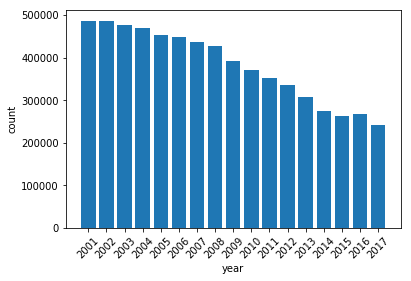

In [13]:
%matplotlib inline
_.bar()

Here we are looking at the total amount of crimes per month.

In [14]:
%%sql
SELECT hour.month_of_year, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour.month_of_year
ORDER BY hour.month_of_year

12 rows affected.


month_of_year,count
1,507475
2,446449
3,536089
4,537774
5,578227
6,575722
7,605146
8,598956
9,562182
10,569547


<Container object of 12 artists>

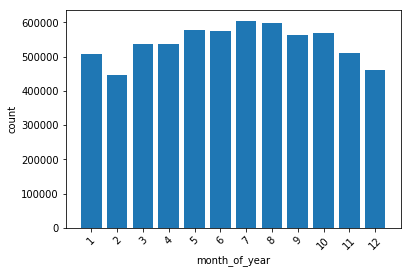

In [15]:
%matplotlib inline
_.bar()

The total amount of crime that occurs on a particular weekday. Fridays are not safe.

In [16]:
%%sql
SELECT hour.day_of_week_str, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour.day_of_week, day_of_week_str 
ORDER BY hour.day_of_week

7 rows affected.


day_of_week_str,count
Sunday,876030
Monday,915620
Tuesday,930330
Wednesday,935978
Thursday,926718
Friday,977472
Saturday,926808


<Container object of 7 artists>

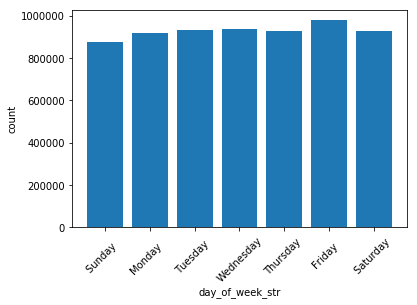

In [17]:
%matplotlib inline
_.bar()

Looking at the time of day - I would consider anything after noon quite dangerous. This is similar to the analysis of LA - anything noon and beyond were much more dangerous.

In [18]:
%%sql
SELECT hour_of_day, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour_of_day
ORDER BY hour_of_day

24 rows affected.


hour_of_day,count
0,360738
1,206442
2,173180
3,139348
4,104494
5,86331
6,101940
7,146904
8,219154
9,277756


<Container object of 24 artists>

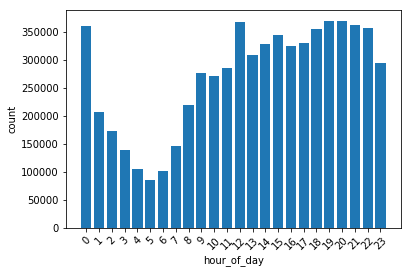

In [19]:
%matplotlib inline
_.bar()

However, our comparison to which day in the year the most crime is committed is also the same, however LA commits almost twice as much crime on New Year's than Chicago does.

In [20]:
%%sql
SELECT a.day, a.year, a.count
FROM (SELECT COUNT(*) AS count, day, hour.year
    FROM chicago_crime
    JOIN hour
    ON chicago_crime.hour_key = hour.key
    GROUP BY day, hour.year) AS a
JOIN (SELECT t.year, MAX(count) AS max_count
    FROM (SELECT COUNT(*) AS count, day, hour.year
        FROM chicago_crime
        JOIN hour
        ON chicago_crime.hour_key = hour.key
        GROUP BY day, hour.year) AS t
     GROUP BY t.year) AS b
ON a.year = b.year
AND a.count = b.max_count
ORDER BY a.year

17 rows affected.


day,year,count
2001-01-01,2001,1810
2002-01-01,2002,1853
2003-01-01,2003,2021
2004-01-01,2004,1884
2005-01-01,2005,1955
2006-01-01,2006,1897
2007-01-01,2007,1933
2008-01-01,2008,1795
2009-01-01,2009,1803
2010-01-01,2010,1404


### Type
Here we are looking at the different types of crime committed in Chicago. Where Battery was the number one crime in LA, Theft followed by Battery are the top two crimes in Chicago.

The number of battery crimes in Chicago is almost 10x more than the battery crimes in LA.

In [21]:
%%sql
SELECT type, COUNT(*)
FROM chicago_crime
GROUP BY type
ORDER BY count DESC
LIMIT 10

10 rows affected.


type,count
THEFT,1355568
BATTERY,1184458
CRIMINAL DAMAGE,744690
NARCOTICS,698473
OTHER OFFENSE,402013
ASSAULT,399086
BURGLARY,376661
MOTOR VEHICLE THEFT,304544
ROBBERY,246085
DECEPTIVE PRACTICE,242619


Here we are looking at how theft and battery has changed throughout the years.

In [22]:
%%sql
SELECT chicago_crime.type, hour.year, COUNT(type)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY type, hour.year
ORDER BY COUNT(type) DESC
LIMIT 10

10 rows affected.


type,year,count
THEFT,2001,99264
THEFT,2003,98875
THEFT,2002,98327
THEFT,2004,95463
BATTERY,2002,94152
BATTERY,2001,93447
THEFT,2008,88431
BATTERY,2003,88377
BATTERY,2004,87134
THEFT,2006,86240


<Container object of 10 artists>

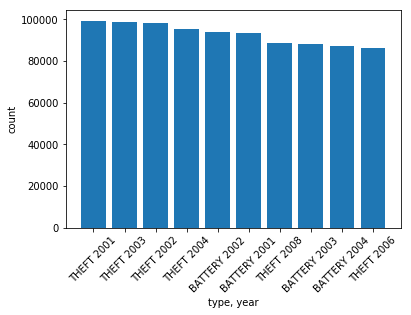

In [23]:
%matplotlib inline
_.bar()

**Focus on Battery**

Here we wanted to compare battery crimes during the week.

In [24]:
%%sql
SELECT type, day_of_week_str, COUNT(type)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
WHERE type = 'BATTERY'
GROUP BY day_of_week, day_of_week_str, type
ORDER BY day_of_week

7 rows affected.


type,day_of_week_str,count
BATTERY,Sunday,194705
BATTERY,Monday,159201
BATTERY,Tuesday,158800
BATTERY,Wednesday,159473
BATTERY,Thursday,159881
BATTERY,Friday,167118
BATTERY,Saturday,185280


<Container object of 7 artists>

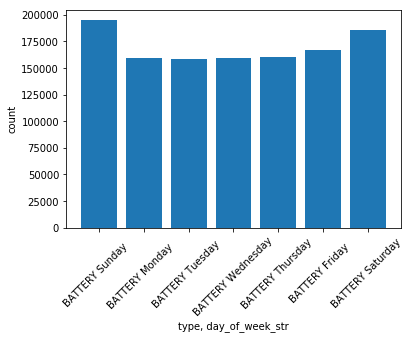

In [25]:
%matplotlib inline
_.bar()

Looking at the time battery crimes occur.

In [26]:
%%sql
SELECT type, hour_of_day, COUNT(type)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
WHERE type = 'BATTERY'
GROUP BY hour_of_day, type
ORDER BY hour_of_day

24 rows affected.


type,hour_of_day,count
BATTERY,0,58892
BATTERY,1,56774
BATTERY,2,50718
BATTERY,3,41074
BATTERY,4,28743
BATTERY,5,19278
BATTERY,6,16215
BATTERY,7,20408
BATTERY,8,31125
BATTERY,9,36646


<Container object of 24 artists>

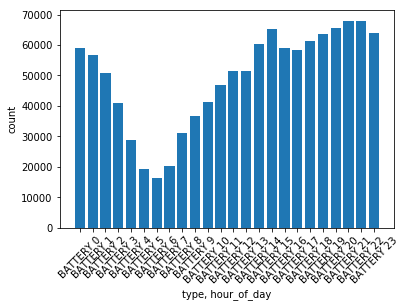

In [27]:
%matplotlib inline
_.bar()

Here we look at where battery crimes occur which is mostly Residences and Apartments, which is similar to LA.

In [28]:
%%sql
SELECT type, location, COUNT(type)
FROM chicago_crime
WHERE type = 'BATTERY'
GROUP BY location, type
ORDER BY COUNT(chicago_crime) DESC
LIMIT 10

10 rows affected.


type,location,count
BATTERY,RESIDENCE,247733
BATTERY,APARTMENT,231556
BATTERY,STREET,212282
BATTERY,SIDEWALK,176332
BATTERY,"SCHOOL, PUBLIC, BUILDING",48685
BATTERY,RESIDENCE PORCH/HALLWAY,29555
BATTERY,ALLEY,26292
BATTERY,OTHER,25862
BATTERY,PARKING LOT/GARAGE(NON.RESID.),15612
BATTERY,CHA APARTMENT,12895


**Location**

However, the majority of crimes occurred on the street followed by residences which is the same as in LA.

In [29]:
%%sql
SELECT location, COUNT(*)
FROM chicago_crime
GROUP BY location
ORDER BY count DESC
LIMIT 5

5 rows affected.


location,count
STREET,1714062
RESIDENCE,1098570
APARTMENT,664071
SIDEWALK,645248
OTHER,245749


Lastly, we wanted to check what type of crime occurred where. Theft occurred mostly on the street, whilst battery occurred mostly within a household.

In [39]:
%%sql
SELECT a.location, a.type, count
FROM (SELECT COUNT(type) AS count, location, type
    FROM chicago_crime
    GROUP BY location, type) AS a
JOIN (SELECT type, MAX(count) AS max_count
    FROM (SELECT COUNT(type) AS count, location, type
        FROM chicago_crime
        GROUP BY location, type) AS t
     GROUP BY t.type) AS b
ON a.type = b.type
AND a.count = b.max_count
ORDER BY count DESC
LIMIT 10

10 rows affected.


location,type,count
STREET,THEFT,373890
STREET,CRIMINAL DAMAGE,269179
STREET,NARCOTICS,248823
RESIDENCE,BATTERY,247733
STREET,MOTOR VEHICLE THEFT,241136
RESIDENCE,OTHER OFFENSE,186784
RESIDENCE,BURGLARY,129213
STREET,ASSAULT,83187
STREET,ROBBERY,75977
RESIDENCE,DECEPTIVE PRACTICE,66578


## Conclusion
In conclusion, although the population of LA is bigger than Chicago, the amount of crime in Chicago is much greater than LA. We would prefer to stay in LA.